In [1]:
import os, sys, time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
pd.options.mode.chained_assignment = None
import h5py
import geopandas as gpd
sys.path.append(os.path.join(os.getcwd(),r'..\..\..'))
# from input_configuration import base_year
import toml
config = toml.load(os.path.join(os.getcwd(),r'../../../configuration/input_configuration.toml'))

%matplotlib inline

from IPython.display import display, HTML

if (sys.version_info < (3, 0)):
    HTML('''<script>
    code_show=true; 
    function code_toggle() {
     if (code_show){
     $('div.input').hide();
     } else {
     $('div.input').show();
     }
     code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
CSS = """
.output {
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(CSS))

# Relative path between notebooks and goruped output directories
relative_path = '../../../outputs'
survey_path = '../../../inputs/base_year/survey'

In [3]:
pd.options.display.float_format = '{:0,.0f}'.format

# Boardings by Agency

In [4]:
df = pd.read_csv(os.path.join(relative_path,'transit','daily_boardings_by_agency.csv'),index_col=0)
df.loc['Region Total','boardings'] = df['boardings'].sum()
df = df.reset_index()
df.rename(columns={'agency_name': 'Agency', 'boardings': 'Boardings'}, inplace=True)
HTML(df.to_html(index=False))

Agency,Boardings
King County Metro,"288,767"
Sound Transit,"126,234"
Kitsap Transit,"33,140"
Community Transit,"20,876"
Pierce Transit,"16,690"
Washington Ferries,"8,406"
Everett Transit,"2,453"
Region Total,"496,566"


# Boardings by Service Type

In [5]:
df = pd.read_csv(os.path.join(relative_path,'transit','transit_line_results.csv'),index_col=0)
# df['mode'] = df['mode'].map({'b': 'Local Bus','f': 'Ferry','r':'Light Rail','c':'Commuter Rail','p':'Ferry'})
# df = df.groupby('mode').sum()[['boardings']]
# df = df.reset_index()
# df.rename(columns={'mode': 'Service Type', 'boardings': 'Boardings'}, inplace=True)
# HTML(df.to_html(index=False))
transit_type_map = {
    1: 'Local Bus',
    2: 'Express Bus',
    3: 'Bus Rapid Transit',
    4: 'Streetcar',
    5: 'Commuter Rail',
    6: 'Light Rail',
    7: 'Auto Ferry',
    8: 'Passenger Ferry'
}
df['transit_type'] = df['transit_type'].map(transit_type_map)
df = df.groupby('transit_type').sum()[['boardings']]
df = df.reset_index()
df.rename(columns={'boardings':' Boardings','transit_type':'Transit Type'}, inplace=True)
HTML(df.to_html(index=False))

Transit Type,Boardings
Auto Ferry,"29,134"
Bus Rapid Transit,"65,656"
Commuter Rail,"9,424"
Light Rail,"63,082"
Local Bus,"329,122"
Passenger Ferry,147


# Trips by Transit Submode
Total numbers of daily trips by transit submode (from Emme trip tables). Trips can include mulitple boardings.

In [6]:
df = pd.read_csv(os.path.join(relative_path,'transit','total_transit_trips.csv'),index_col=0)
df.rename(index={'commuter_rail': 'Commuter Rail',
                'litrat': 'Light Rail',
                'ferry': 'Auto Ferry',
                'passenger_ferry': 'Passenger Ferry',
                'trnst': 'Bus'}, inplace=True)
df.columns = ['Total Trips']
df.loc['Total'] = df.sum(axis=0)
df

,Total Trips
Commuter Rail,"10,491"
Light Rail,"61,771"
Auto Ferry,"27,472"
Passenger Ferry,274
Bus,"240,200"
Total,"340,207"


# High Capacity Transit (HCT)

In [7]:
# List of Stations
# Load transit stops file

#"The definition we have been using for the RTP is BRT, LRT, Commuter Rail, StreetCar and Ferry."
df = pd.read_csv(r'../../../inputs/scenario/networks/transit_stops.csv')
# Streetcar is coded as light rail
df['hct'] = 0
df.loc[df[['commuter_rail','light_rail','ferry','brt']].sum(axis=1) > 0,'hct'] = 1
df_hct = df[df['hct'] == 1]

In [8]:
# Map of Stations
# Load as a geodataframe
gdf_hct = gpd.GeoDataFrame(
    df_hct, geometry=gpd.points_from_xy(df_hct.x, df_hct.y))

crs = {'init' : 'EPSG:2285'}
gdf_hct.crs = crs

## HCT Station Location

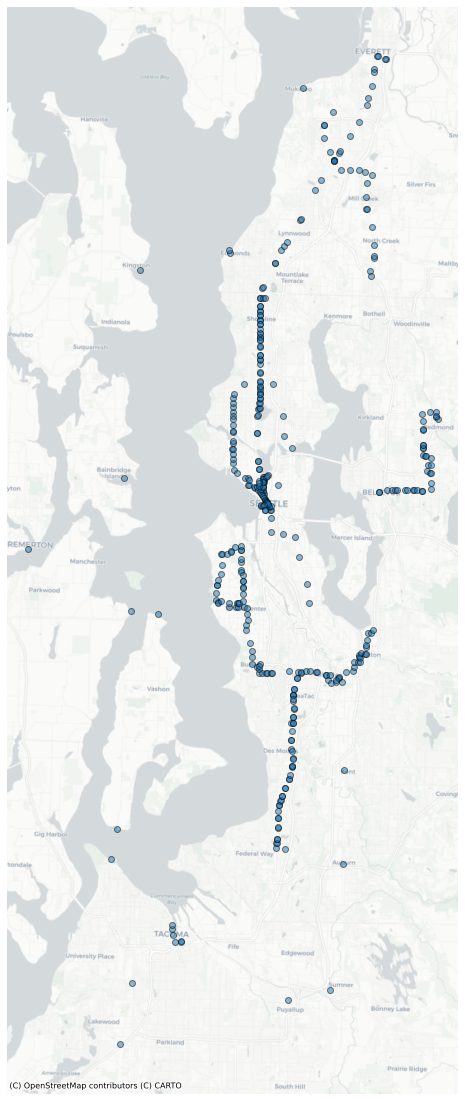

In [9]:
import contextily as ctx
ax = gdf_hct.plot(figsize=(20,20), alpha=0.5, edgecolor='k')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=crs)
ax.set_axis_off()

In [10]:
# Export stops as a shapefile
# gdf_hct.to_file(os.path.join(relative_path,'hct_stops.shp'))

## HCT Network

In [11]:
df = pd.read_csv(os.path.join(relative_path,'transit','transit_line_results.csv'),index_col=0)
df_hct = df[df['transit_type'].isin([2,3,4,5,6,7,8])]  # see transit_type_map for lookup
df_segments = pd.read_csv(r'..\..\..\inputs\scenario\networks\shapefiles\AM\AM_transit_segments.csv')


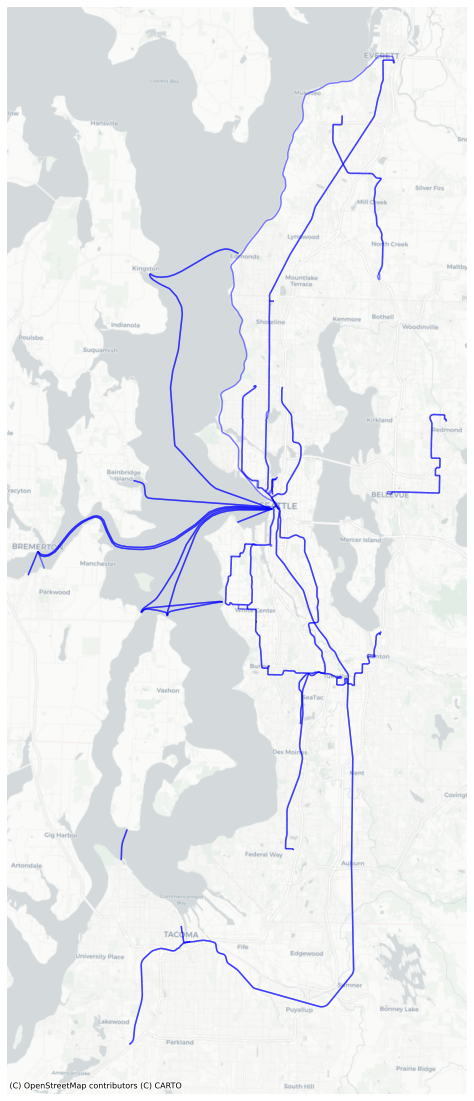

In [12]:
df_network = gpd.read_file(r'../../../inputs/scenario/networks/shapefiles/AM/AM_edges.shp')
hct_segments = df_segments[df_segments['route_id'].isin(df_hct.index)]
hct_network = df_network[df_network['id'].isin(hct_segments['ij'])]
hct_network.crs = crs
ax = hct_network.plot(figsize=(10,20), alpha=0.5, edgecolor='b')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, crs=crs)
ax.set_axis_off()

## Households Living Near HCT Stations
Within one quarter (1/4) or one half (1/2) miles of HCT station. Results are presented as total households and percent of households within a given geography. 

In [13]:
df_lu = pd.read_csv(r'..\..\..\inputs\scenario\landuse\parcels_urbansim.txt',
                   delim_whitespace=True)

# Load as a geodataframe
gdf_lu = gpd.GeoDataFrame(
    df_lu, geometry=gpd.points_from_xy(df_lu.XCOORD_P, df_lu.YCOORD_P))

crs = {'init' : 'EPSG:2285'}
gdf_lu.crs = crs

In [14]:
parcel_geog = pd.read_sql_table('parcel_'+config['base_year']+'_geography', 'sqlite:///../../../inputs/db/'+config['db_name'])

In [15]:
df_lu = df_lu.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')
# Add a field that defines whether a parcel is inside (1) or outside (0) any RGC
df_lu['RGC_binary'] = 0
df_lu.loc[df_lu['GrowthCenterName'] != 'Not in RGC', 'RGC_binary'] = 1

In [16]:
def calculate_buffer(gdf_lu, gdf_network, distance):
    
    # Buffer the HCT station gdf
    gdf_network['geometry'] = gdf_network.buffer(distance)

    gdf_intersect = gpd.overlay(gdf_network, gdf_lu, how="intersection", keep_geom_type=False)
    df = df_lu[df_lu['PARCELID'].isin(gdf_intersect['PARCELID'].unique())]

#     df = df.merge(parcel_geog,left_on='PARCELID', right_on='ParcelID')
    
    return df

In [17]:
def aggregate_parcels(df, col_dict, sum_field):
    results_df = pd.DataFrame()
    for col, name in col_dict.items():
        _df = df.groupby(col).sum()[[sum_field]]
        _df['group'] = name
        results_df = results_df.append(_df)
    results_df = results_df.reset_index()
    
    return results_df

In [18]:
df_025 = calculate_buffer(gdf_lu, gdf_hct, distance=5280.0/4)

In [19]:
df_050 = calculate_buffer(gdf_lu, gdf_hct, distance=5280.0/2)

In [20]:
pd.options.display.float_format = '{:0,.0f}'.format
col_dict = {'racial_geog_vs_reg_total': 'Race',
                      'poverty_geog_vs_reg_total': 'Poverty',
                        'english_geog_vs_reg_total': 'English',
                      'elderly_geog_vs_reg_total': 'Elderly',
                      'youth_geog_vs_reg_total': 'Youth',
            'disability_geog_vs_reg_total': 'Disability',
            'racial_geog_vs_50_percent': 'Race 50%',
            'poverty_geog_vs_50_percent': 'Poverty 50%',
           'rg_proposed': 'Regional Geography',
            'CountyName': 'County',
            'GrowthCenterName': 'Regional Growth Center',
            'RGC_binary': 'RGC Binary',
            'Region': 'Region'
           }

hct_hh_df = pd.DataFrame()
df_025['Region'] = 1
df = aggregate_parcels(df_025, col_dict, 'HH_P')
df['distance'] = 0.25
hct_hh_df = hct_hh_df.append(df)
df_050['Region'] = 1
df = aggregate_parcels(df_050, col_dict, 'HH_P')
df['distance'] = 0.50
hct_hh_df = hct_hh_df.append(df)

In [21]:
pd.options.display.float_format = '{:0,.0f}'.format

### Region
Total households within given distance of HCT stations, regionwide

In [22]:
hct_hh_df['group'].unique()

array(['Race', 'Poverty', 'English', 'Elderly', 'Youth', 'Disability',
       'Race 50%', 'Poverty 50%', 'Regional Geography', 'County',
       'Regional Growth Center', 'RGC Binary', 'Region'], dtype=object)

In [23]:

df = hct_hh_df[hct_hh_df['group'] == 'Region']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Region'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)

df['% of Households (1/4 Mile)'] = df['1/4 Mile']/df_lu['HH_P'].sum()
df['% of Households (1/2 Mile)'] = df['1/2 Mile']/df_lu['HH_P'].sum()

output = df.to_html(formatters={
    '% of Households (1/4 Mile)': '{:0,.1%}'.format,
    '% of Households (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Region,1/4 Mile,1/2 Mile,% of Households (1/4 Mile),% of Households (1/2 Mile)
1,"185,879","511,061",10.7%,29.4%


### Counties
Total households within given distance of HCT stations by county

In [24]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df[hct_hh_df['group'] == 'County']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'County'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)

_df = df.merge(df_lu.groupby('CountyName').sum()[['HH_P']].reset_index(),left_on='County', right_on='CountyName')
_df['% of Households (1/4 Mile)'] = _df['1/4 Mile']/_df['HH_P']
_df['% of Households (1/2 Mile)'] = _df['1/2 Mile']/_df['HH_P']

df = df.merge(_df[['County', '% of Households (1/4 Mile)', '% of Households (1/2 Mile)']], 
              on='County')

output = df.to_html(formatters={
    '% of Households (1/4 Mile)': '{:0,.1%}'.format,
    '% of Households (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

County,1/4 Mile,1/2 Mile,% of Households (1/4 Mile),% of Households (1/2 Mile)
King,"164,703","397,600",17.2%,41.5%
Kitsap,202,"4,855",0.2%,4.5%
Pierce,"3,047","20,982",0.9%,6.0%
Snohomish,"17,927","87,624",5.6%,27.4%


### Regional Growth Centers

In [25]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df[hct_hh_df['group'] == 'RGC Binary']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'RGC Binary'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)


_df = df.merge(df_lu.groupby('RGC_binary').sum()[['HH_P']].reset_index(),left_on='RGC Binary', 
               right_on='RGC_binary')
_df['% of Households (1/4 Mile)'] = _df['1/4 Mile']/_df['HH_P']
_df['% of Households (1/2 Mile)'] = _df['1/2 Mile']/_df['HH_P']

df = df.merge(_df[['RGC Binary', '% of Households (1/4 Mile)', '% of Households (1/2 Mile)']], 
              on='RGC Binary')
df['RGC Designation'] = df['RGC Binary'].map({0: 'Outside RGC', 1: 'Inside RGC'})
df = df[['RGC Designation','1/4 Mile','1/2 Mile','% of Households (1/4 Mile)', '% of Households (1/2 Mile)']]
output = df.to_html(formatters={
    '% of Households (1/4 Mile)': '{:0,.1%}'.format,
    '% of Households (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

RGC Designation,1/4 Mile,1/2 Mile,% of Households (1/4 Mile),% of Households (1/2 Mile)
Outside RGC,"110,771","365,305",7.1%,23.3%
Inside RGC,"75,108","145,756",44.4%,86.2%


In [26]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df[hct_hh_df['group'] == 'Regional Growth Center']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Growth Center'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)

# Calcualte the percent of households in this geography within 1/4 and 1/2 mile

_df = df.merge(df_lu.groupby('GrowthCenterName').sum()[['HH_P']].reset_index(),left_on='Regional Growth Center', 
               right_on='GrowthCenterName')
_df['% of Households (1/4 Mile)'] = _df['1/4 Mile']/_df['HH_P']
_df['% of Households (1/2 Mile)'] = _df['1/2 Mile']/_df['HH_P']

df = df.merge(_df[['Regional Growth Center', '% of Households (1/4 Mile)', '% of Households (1/2 Mile)']], 
              on='Regional Growth Center')

output = df.to_html(formatters={
    '% of Households (1/4 Mile)': '{:0,.1%}'.format,
    '% of Households (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Regional Growth Center,1/4 Mile,1/2 Mile,% of Households (1/4 Mile),% of Households (1/2 Mile)
Auburn,664,967,68.7%,100.0%
Ballard-Interbay,59,114,51.8%,100.0%
Bellevue,"3,049","9,828",31.0%,100.0%
Bothell Canyon Park,120,358,33.5%,100.0%
Bremerton,117,"1,549",7.2%,95.7%
Burien,"1,737","1,916",90.7%,100.0%
Duwamish,1,22,0.4%,9.6%
Everett,"1,563","3,913",39.9%,100.0%
Federal Way,232,232,100.0%,100.0%
Kent,332,973,34.1%,100.0%


### Regional Geographies

In [27]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df[hct_hh_df['group'] == 'Regional Geography']
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
# HTML(df.to_html(index=False))

_df = df.merge(df_lu.groupby('rg_proposed').sum()[['HH_P']].reset_index(),left_on='Regional Geography', 
               right_on='rg_proposed')
_df['% of Households (1/4 Mile)'] = _df['1/4 Mile']/_df['HH_P']
_df['% of Households (1/2 Mile)'] = _df['1/2 Mile']/_df['HH_P']

df = df.merge(_df[['Regional Geography', '% of Households (1/4 Mile)', '% of Households (1/2 Mile)']], 
              on='Regional Geography')

output = df.to_html(formatters={
    '% of Households (1/4 Mile)': '{:0,.1%}'.format,
    '% of Households (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Regional Geography,1/4 Mile,1/2 Mile,% of Households (1/4 Mile),% of Households (1/2 Mile)
CitiesTowns,0,521,0.0%,0.4%
Core,"31,937","93,440",8.3%,24.2%
HCT,"19,482","72,189",5.4%,20.0%
Metro,"133,470","340,663",22.6%,57.7%
Rural,89,660,0.0%,0.3%
UU,901,"3,588",1.4%,5.5%


### Equity Geographies

In [28]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df.copy()
df = df[df['index'] == 1]
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df.drop('index', axis=1, inplace=True)
df = df.pivot_table(index='group', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Equity Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)


equity_dict = {'racial_geog_vs_reg_total': 'Race',
                      'poverty_geog_vs_reg_total': 'Poverty',
                        'english_geog_vs_reg_total': 'English',
                      'elderly_geog_vs_reg_total': 'Elderly',
                      'youth_geog_vs_reg_total': 'Youth',
            'disability_geog_vs_reg_total': 'Disability',
            'racial_geog_vs_50_percent': 'Race 50%',
            'poverty_geog_vs_50_percent': 'Poverty 50%'}
results_dict = {}
for key, val in equity_dict.items():
    _df = df_lu.groupby(key).sum()[['HH_P']].reset_index()
    results_dict[val] = _df[_df[key] == 1]['HH_P'].values[0]

results_df = pd.DataFrame(results_dict.values(), index=results_dict.keys(), columns=['Total HH'])
results_df = results_df.reset_index()
results_df = results_df.merge(df,left_on='index', right_on='Equity Geography')

results_df['% of Households (1/4 Mile)'] = results_df['1/4 Mile']/results_df['Total HH']
results_df['% of Households (1/2 Mile)'] = results_df['1/2 Mile']/results_df['Total HH']



df = df.merge(results_df[['Equity Geography', '% of Households (1/4 Mile)', '% of Households (1/2 Mile)']], 
              on='Equity Geography')

output = df.to_html(formatters={
    '% of Households (1/4 Mile)': '{:0,.1%}'.format,
    '% of Households (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Equity Geography,1/4 Mile,1/2 Mile,% of Households (1/4 Mile),% of Households (1/2 Mile)
Disability,"76,651","213,856",9.5%,26.6%
Elderly,"58,370","181,718",7.3%,22.6%
English,"85,999","250,643",13.3%,38.7%
Poverty,"89,589","259,011",12.2%,35.4%
Poverty 50%,"9,113","21,584",21.3%,50.4%
Race,"124,271","303,437",15.9%,38.7%
Race 50%,"60,216","157,964",16.9%,44.4%
Youth,"27,086","113,265",3.2%,13.3%


In [29]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df.copy()
df = df[df['index'] == 0]
df.rename(columns={'HH_P': 'Total'}, inplace=True)
df.drop('index', axis=1, inplace=True)
df = df.pivot_table(index='group', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Equity Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)


equity_dict = {'racial_geog_vs_reg_total': 'Race',
                      'poverty_geog_vs_reg_total': 'Poverty',
                        'english_geog_vs_reg_total': 'English',
                      'elderly_geog_vs_reg_total': 'Elderly',
                      'youth_geog_vs_reg_total': 'Youth',
            'disability_geog_vs_reg_total': 'Disability',
            'racial_geog_vs_50_percent': 'Race 50%',
            'poverty_geog_vs_50_percent': 'Poverty 50%'}
results_dict = {}
for key, val in equity_dict.items():
    _df = df_lu.groupby(key).sum()[['HH_P']].reset_index()
    results_dict[val] = _df[_df[key] == 0]['HH_P'].values[0]

results_df = pd.DataFrame(results_dict.values(), index=results_dict.keys(), columns=['Total HH'])
results_df = results_df.reset_index()
results_df = results_df.merge(df,left_on='index', right_on='Equity Geography')

results_df['% of Households (1/4 Mile)'] = results_df['1/4 Mile']/results_df['Total HH']
results_df['% of Households (1/2 Mile)'] = results_df['1/2 Mile']/results_df['Total HH']



df = df.merge(results_df[['Equity Geography', '% of Households (1/4 Mile)', '% of Households (1/2 Mile)']], 
              on='Equity Geography')
df['Equity Geography'] = ['NOT in '+i for i in df['Equity Geography']]
output = df.to_html(formatters={
    '% of Households (1/4 Mile)': '{:0,.1%}'.format,
    '% of Households (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Equity Geography,1/4 Mile,1/2 Mile,% of Households (1/4 Mile),% of Households (1/2 Mile)
NOT in Disability,"109,228","297,205",11.7%,31.8%
NOT in Elderly,"127,509","329,343",13.7%,35.3%
NOT in English,"99,880","260,418",9.2%,23.9%
NOT in Poverty,"96,290","252,050",9.6%,25.1%
NOT in Poverty 50%,"176,766","489,477",10.4%,28.9%
NOT in Race,"61,608","207,624",6.5%,21.8%
NOT in Race 50%,"125,663","353,097",9.1%,25.6%
NOT in Youth,"158,793","397,796",18.0%,45.1%


# Jobs Near HCT Stations
Total jobs and percent of total jobs

### Region

In [30]:
pd.options.display.float_format = '{:0,.0f}'.format
col_dict = {'racial_geog_vs_reg_total': 'Race',
                      'poverty_geog_vs_reg_total': 'Poverty',
                        'english_geog_vs_reg_total': 'English',
                      'elderly_geog_vs_reg_total': 'Elderly',
                      'youth_geog_vs_reg_total': 'Youth',
            'disability_geog_vs_reg_total': 'Disability',
            'racial_geog_vs_50_percent': 'Race 50%',
            'poverty_geog_vs_50_percent': 'Poverty 50%',
           'rg_proposed': 'Regional Geography',
            'CountyName': 'County',
            'GrowthCenterName': 'Regional Growth Center',
            'RGC_binary': 'RGC Binary',
            'Region': 'Region'
           }

hct_hh_df = pd.DataFrame()
df_025['Region'] = 1
df = aggregate_parcels(df_025, col_dict, 'EMPTOT_P')
df['distance'] = 0.25
hct_hh_df = hct_hh_df.append(df)
df_050['Region'] = 1
df = aggregate_parcels(df_050, col_dict, 'EMPTOT_P')
df['distance'] = 0.50
hct_hh_df = hct_hh_df.append(df)

In [31]:
pd.options.display.float_format = '{:0,.0f}'.format

In [32]:

df = hct_hh_df[hct_hh_df['group'] == 'Region']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Region'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)

df['% of Jobs (1/4 Mile)'] = df['1/4 Mile']/df_lu['EMPTOT_P'].sum()
df['% of Jobs (1/2 Mile)'] = df['1/2 Mile']/df_lu['EMPTOT_P'].sum()

output = df.to_html(formatters={
    '% of Jobs (1/4 Mile)': '{:0,.1%}'.format,
    '% of Jobs (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Region,1/4 Mile,1/2 Mile,% of Jobs (1/4 Mile),% of Jobs (1/2 Mile)
1,"560,220","1,084,754",25.6%,49.7%


### Counties

In [33]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df[hct_hh_df['group'] == 'County']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'County'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)

_df = df.merge(df_lu.groupby('CountyName').sum()[['EMPTOT_P']].reset_index(),left_on='County', right_on='CountyName')
_df['% of Jobs (1/4 Mile)'] = _df['1/4 Mile']/_df['EMPTOT_P']
_df['% of Jobs (1/2 Mile)'] = _df['1/2 Mile']/_df['EMPTOT_P']

df = df.merge(_df[['County', '% of Jobs (1/4 Mile)', '% of Jobs (1/2 Mile)']], 
              on='County')

output = df.to_html(formatters={
    '% of Jobs (1/4 Mile)': '{:0,.1%}'.format,
    '% of Jobs (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

County,1/4 Mile,1/2 Mile,% of Jobs (1/4 Mile),% of Jobs (1/2 Mile)
King,"509,266","880,489",34.8%,60.2%
Kitsap,970,"21,387",1.0%,21.7%
Pierce,"17,905","64,601",5.5%,19.8%
Snohomish,"32,079","118,277",10.7%,39.6%


### Regional Growth Centers

In [34]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df[hct_hh_df['group'] == 'RGC Binary']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'RGC Binary'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)


_df = df.merge(df_lu.groupby('RGC_binary').sum()[['EMPTOT_P']].reset_index(),left_on='RGC Binary', 
               right_on='RGC_binary')
_df['% of Jobs (1/4 Mile)'] = _df['1/4 Mile']/_df['EMPTOT_P']
_df['% of Jobs (1/2 Mile)'] = _df['1/2 Mile']/_df['EMPTOT_P']

df = df.merge(_df[['RGC Binary', '% of Jobs (1/4 Mile)', '% of Jobs (1/2 Mile)']], 
              on='RGC Binary')
df['RGC Designation'] = df['RGC Binary'].map({0: 'Outside RGC', 1: 'Inside RGC'})
df = df[['RGC Designation','1/4 Mile','1/2 Mile','% of Jobs (1/4 Mile)', '% of Jobs (1/2 Mile)']]
output = df.to_html(formatters={
    '% of Jobs (1/4 Mile)': '{:0,.1%}'.format,
    '% of Jobs (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

RGC Designation,1/4 Mile,1/2 Mile,% of Jobs (1/4 Mile),% of Jobs (1/2 Mile)
Outside RGC,"132,265","374,421",10.6%,29.9%
Inside RGC,"427,955","710,333",46.0%,76.3%


In [35]:
pd.options.display.float_format = '{:0,.0f}'.format
df = hct_hh_df[hct_hh_df['group'] == 'Regional Growth Center']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Growth Center'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
df['% of Total Jobs (1/4 Mile)'] = df['1/4 Mile']/df_lu['EMPTOT_P'].sum()
df['% of Total Jobs (1/2 Mile)'] = df['1/2 Mile']/df_lu['EMPTOT_P'].sum()

output = df.to_html(formatters={
    '% of Total Jobs (1/4 Mile)': '{:0,.1%}'.format,
    '% of Total Jobs (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Regional Growth Center,1/4 Mile,1/2 Mile,% of Total Jobs (1/4 Mile),% of Total Jobs (1/2 Mile)
Auburn,"2,372","4,207",0.1%,0.2%
Ballard-Interbay,"7,377","14,774",0.3%,0.7%
Bellevue,"29,058","52,728",1.3%,2.4%
Bothell Canyon Park,381,"10,258",0.0%,0.5%
Bremerton,580,"17,747",0.0%,0.8%
Burien,"3,550","3,851",0.2%,0.2%
Duwamish,"6,959","33,291",0.3%,1.5%
Everett,"8,288","13,404",0.4%,0.6%
Federal Way,"1,101","1,666",0.1%,0.1%
Kent,"2,743","6,058",0.1%,0.3%


### Regional Geographies

In [36]:
df = hct_hh_df[hct_hh_df['group'] == 'Regional Geography']
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df = df.pivot_table(index='index', columns='distance', values='Total', aggfunc='sum')
df = df.fillna(0)
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Regional Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
df['% of Total Jobs (1/4 Mile)'] = df['1/4 Mile']/df_lu['EMPTOT_P'].sum()
df['% of Total Jobs (1/2 Mile)'] = df['1/2 Mile']/df_lu['EMPTOT_P'].sum()

output = df.to_html(formatters={
    '% of Total Jobs (1/4 Mile)': '{:0,.1%}'.format,
    '% of Total Jobs (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Regional Geography,1/4 Mile,1/2 Mile,% of Total Jobs (1/4 Mile),% of Total Jobs (1/2 Mile)
CitiesTowns,0,659,0.0%,0.0%
Core,"137,616","262,966",6.3%,12.0%
HCT,"22,323","59,024",1.0%,2.7%
Metro,"399,481","758,536",18.3%,34.7%
Rural,32,48,0.0%,0.0%
UU,768,"3,521",0.0%,0.2%


### Equity Geographies


In [37]:
# df = aggregate_parcels(df_lu, col_dict, 'HH_P')
df = hct_hh_df.copy()
df = df[df['index'] == 1]
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df.drop('index', axis=1, inplace=True)
df = df.pivot_table(index='group', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Equity Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
df['% of Total Jobs (1/4 Mile)'] = df['1/4 Mile']/df_lu['EMPTOT_P'].sum()
df['% of Total Jobs (1/2 Mile)'] = df['1/2 Mile']/df_lu['EMPTOT_P'].sum()



output = df.to_html(formatters={
    '% of Total Jobs (1/4 Mile)': '{:0,.1%}'.format,
    '% of Total Jobs (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Equity Geography,1/4 Mile,1/2 Mile,% of Total Jobs (1/4 Mile),% of Total Jobs (1/2 Mile)
Disability,"317,900","598,724",14.6%,27.4%
Elderly,"242,166","424,030",11.1%,19.4%
English,"245,112","511,064",11.2%,23.4%
Poverty,"324,206","621,701",14.8%,28.5%
Poverty 50%,"13,803","59,197",0.6%,2.7%
RGC Binary,"427,955","710,333",19.6%,32.5%
Race,"421,866","770,337",19.3%,35.3%
Race 50%,"164,450","334,160",7.5%,15.3%
Region,"560,220","1,084,754",25.6%,49.7%
Youth,"48,016","152,045",2.2%,7.0%


In [38]:
# df = aggregate_parcels(df_lu, col_dict, 'HH_P')
df = hct_hh_df.copy()
df = df[df['index'] == 0]
df.rename(columns={'EMPTOT_P': 'Total'}, inplace=True)
df.drop('index', axis=1, inplace=True)
df = df.pivot_table(index='group', columns='distance', values='Total', aggfunc='sum')
df[0.25] = df[0.25].astype('float32')
df[0.5] = df[0.5].astype('float32')
df.index.name = 'Equity Geography'
df = df.reset_index()
df = df.rename_axis(None, axis=1)
df.rename(columns={0.25: '1/4 Mile', 0.5: '1/2 Mile'}, inplace=True)
df['% of Total Jobs (1/4 Mile)'] = df['1/4 Mile']/df_lu['EMPTOT_P'].sum()
df['% of Total Jobs (1/2 Mile)'] = df['1/2 Mile']/df_lu['EMPTOT_P'].sum()
df['Equity Geography'] = ['NOT in '+i for i in df['Equity Geography']]
output = df.to_html(formatters={
    '% of Total Jobs (1/4 Mile)': '{:0,.1%}'.format,
    '% of Total Jobs (1/2 Mile)': '{:0,.1%}'.format,
}, index=False)
display(HTML(output))

Equity Geography,1/4 Mile,1/2 Mile,% of Total Jobs (1/4 Mile),% of Total Jobs (1/2 Mile)
NOT in Disability,"242,320","486,030",11.1%,22.3%
NOT in Elderly,"318,054","660,724",14.6%,30.3%
NOT in English,"315,108","573,690",14.4%,26.3%
NOT in Poverty,"236,014","463,053",10.8%,21.2%
NOT in Poverty 50%,"546,417","1,025,557",25.0%,47.0%
NOT in RGC Binary,"132,265","374,421",6.1%,17.1%
NOT in Race,"138,354","314,417",6.3%,14.4%
NOT in Race 50%,"395,770","750,594",18.1%,34.4%
NOT in Youth,"512,204","932,709",23.5%,42.7%


# Transfers
Transfers between transit modes
- rows are the initial mode and columns are the mode transfered to

In [39]:
# df_transfers = pd.read_csv(r'../../../outputs/transit/transit_transfers.csv')
# # df_transfers['boardings'] = df_transfers['boardings'].astype('float')
# df_line = pd.read_csv(os.path.join(relative_path,'transit','transit_line_results.csv'))

# transit_type_map = {
#     1: 'Local Bus',
#     2: 'Express Bus',
#     3: 'Bus Rapid Transit',
#     4: 'Streetcar',
#     5: 'Commuter Rail',
#     6: 'Light Rail',
#     7: 'Auto Ferry',
#     8: 'Passenger Ferry'
# }

# transit_type_df = df_line.groupby('line_id').first()[['transit_type']].reset_index()
# transit_type_df['transit_type'] = transit_type_df['transit_type'].map(transit_type_map)

# df_from = df_transfers.merge(transit_type_df[['transit_type','line_id']], 
#                              left_on='from_line_id', right_on='line_id', how='left')
# # df = df_from.merge(df_from.merge(df_line[['transit_type']], left_on='to_line_id', right_index=True, how='left',
# #                                      suffixes=['_from','_to']))
# df = df_from.merge(transit_type_df[['transit_type','line_id']], 
#                              left_on='to_line_id', right_on='line_id', how='left', suffixes=['_from','_to'])

In [40]:
# _df = df.pivot_table(index='transit_type_from', columns='transit_type_to', values='boardings', aggfunc='sum')
# _df = _df.fillna(0)
# _df

In [41]:
df

,Equity Geography,1/4 Mile,1/2 Mile,% of Total Jobs (1/4 Mile),% of Total Jobs (1/2 Mile)
0,NOT in Disability,"242,320","486,030",0,0
1,NOT in Elderly,"318,054","660,724",0,0
2,NOT in English,"315,108","573,690",0,0
3,NOT in Poverty,"236,014","463,053",0,0
4,NOT in Poverty 50%,"546,417","1,025,557",0,0
5,NOT in RGC Binary,"132,265","374,421",0,0
6,NOT in Race,"138,354","314,417",0,0
7,NOT in Race 50%,"395,770","750,594",0,0
8,NOT in Youth,"512,204","932,709",0,0


#### Transit Mode for Transfers to HCT Routes
e.g., rode local bus to HCT route

In [42]:
# # Total number of transfers to HCT from transit modes
# _df = df.groupby(['transit_type_from','transit_type_to']).sum()[['boardings']].reset_index()
# _df
# # _df.groupby('transit_type_from').sum()[['boardings']]

#### Transit Mode for Transfers from HCT Routes
e.g., took local bus after using HCT route

In [43]:
# # Total number of transfers to HCT from transit modes
# _df.groupby('transit_type_to').sum()[['boardings']]

# Transit Access Mode
### Percent of Transit Trips Accessed by Walking

#### Region

In [44]:
pd.options.display.float_format = '{:0,.1%}'.format
df = pd.read_csv(r'../../../outputs/agg/dash/trip_mode_by_tour_mode.csv')
_df = df.copy()
pnr_transit_trips = _df[(_df['tmodetp'] == 'Park') & (_df['mode'] == 'Transit')]['trexpfac'].sum()
walk_transit_trips = _df[(_df['tmodetp'] == 'Transit') & (_df['mode'] == 'Transit')]['trexpfac'].sum()
reg_access = (walk_transit_trips/(walk_transit_trips+pnr_transit_trips))
pd.DataFrame([reg_access], columns=['% Transit trips Accessed by Walking'], index=['Region'])


,% Transit trips Accessed by Walking
Region,88.0%


#### Equity Geographies

In [45]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = df.copy()
results_df = pd.DataFrame()
list_50 = ['hh_racial','hh_poverty']
for col in ['hh_disability','hh_elderly','hh_english','hh_poverty','hh_racial','hh_youth']:
    for suffix in ['_reg', '_50']:
        pnr_transit_trips = _df[(_df[col+suffix] == 1) & 
                                (_df['tmodetp'] == 'Park') &
                                (_df['mode'] == 'Transit')]['trexpfac'].sum()
        walk_transit_trips = _df[(_df[col+suffix] == 1) & 
                                  (_df['tmodetp'] == 'Transit') & 
                                  (_df['mode'] == 'Transit')]['trexpfac'].sum()
        if (pnr_transit_trips > 0) & (walk_transit_trips > 0):
            if suffix == '_reg' or col in list_50:
                results_df.loc[col+suffix,'% Transit Trips Accessed by Walking'] = walk_transit_trips/(walk_transit_trips+pnr_transit_trips)
# results_df.rename(columns={'_reg':'> Regional Average', '_50': '> 50%'}, inplace=True)
results_df

,% Transit Trips Accessed by Walking
hh_disability_reg,88.4%
hh_elderly_reg,88.1%
hh_english_reg,88.1%
hh_poverty_reg,91.0%
hh_poverty_50,95.2%
hh_racial_reg,89.3%
hh_racial_50,90.1%
hh_youth_reg,79.4%


In [46]:
pd.options.display.float_format = '{:0,.1%}'.format
_df = df.copy()
results_df = pd.DataFrame()
list_50 = ['hh_racial','hh_poverty']
for col in ['hh_disability','hh_elderly','hh_english','hh_poverty','hh_racial','hh_youth']:
    for suffix in ['_reg', '_50']:
        pnr_transit_trips = _df[(_df[col+suffix] == 0) & 
                                (_df['tmodetp'] == 'Park') &
                                (_df['mode'] == 'Transit')]['trexpfac'].sum()
        walk_transit_trips = _df[(_df[col+suffix] == 0) & 
                                  (_df['tmodetp'] == 'Transit') & 
                                  (_df['mode'] == 'Transit')]['trexpfac'].sum()
        if (pnr_transit_trips > 0) & (walk_transit_trips > 0):
            if suffix == '_reg' or col in list_50:
                results_df.loc[col+suffix,'% Transit Trips Accessed by Walking'] = walk_transit_trips/(walk_transit_trips+pnr_transit_trips)
# results_df.rename(columns={'_reg':'> Regional Average', '_50': '> 50%'}, inplace=True)
results_df.index = ['NOT in '+i for i in results_df.index]
results_df

,% Transit Trips Accessed by Walking
NOT in hh_disability_reg,87.6%
NOT in hh_elderly_reg,87.9%
NOT in hh_english_reg,87.9%
NOT in hh_poverty_reg,85.2%
NOT in hh_poverty_50,87.7%
NOT in hh_racial_reg,86.7%
NOT in hh_racial_50,87.3%
NOT in hh_youth_reg,92.2%
